# Bayesian Linear Regression 

Dataset represents refrigerator price as a function of covariates:


PRICE    - Response, cost of refrigerator   
RSIZE    - Size in cubic feet   
FSIZE    - Size of freezer compartment    
ECOST    - Annual energy cost to operate refrigerator   
SHELVES  - Number of shelves   
FEATURES - Number of features   
BRAND    - Manufacturer     
   

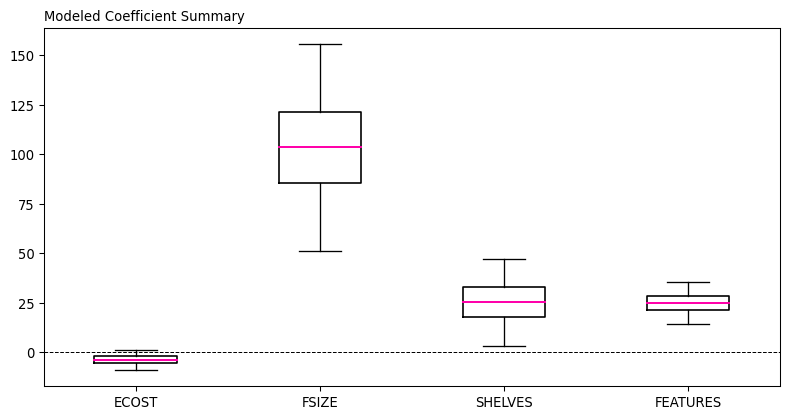

In [1]:
%matplotlib inline
import functools
import itertools
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from scipy import stats
from scipy.linalg import cholesky
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse

pd.options.mode.chained_assignment = None # 'warn'
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 10000)
np.set_printoptions(
    edgeitems=3, linewidth=500, suppress=True, nanstr='NaN',
    infstr='Inf', precision=5
    )

#"G:\\Datasets\\Multiple_Linear_Regression\\Refrigerator.csv"
DATA_URL = "https://gist.github.com/jtrive84/96757393423b2599c7d5da361fdf024b/raw/82000835b7c3b70dcf21a9ab43c59db700b78136/Refrigerator.csv"


def bxp_stats(mdlfit):
    """
    Return a list of dicts representing statistics necessary to produce
    boxplot summaries of regression parameters. 
    
    Parameters
    ----------
    mdlfit: statsmodels.regression.linear_model.RegressionResultsWrapper
        statsmodels regression output summary. 
        
    Returns
    -------
    list of dicts
    
    Reference
    ---------
    https://matplotlib.org/3.1.1/gallery/statistics/bxp.html
    """
    dfparams = get_params_summary(mdlfit=mdlfit)
    dfparams = dfparams[dfparams.index!="Intercept"]
    statslist = []
    for param in dfparams.index:
        mu = dfparams[dfparams.index==param].coef.values[0]
        s = dfparams[dfparams.index==param].std_err.values[0]
        dist = stats.norm(loc=mu, scale=s)
        dqr = {q:stats.norm.ppf(q=q, loc=mu, scale=s) for q in (.025, .25, .50, .75, .975,)}
        dparam = {
            "label":param,
            "mean":dfparams[dfparams.index==param].coef.values[0], 
            "iqr":dist.ppf(.75) - dist.ppf(.25),
            "whishi":dist.ppf(.975),
            "whislo":dist.ppf(.025),
            "fliers":np.asarray([]), 
            "q1":dist.ppf(.25),
            "med": dist.median(),
            "q3":dist.ppf(.75),
            #"cilo": dist.ppf(.10),
            #"cihi":dist.ppf(.90),
            }
        statslist.append(dparam)
    return(statslist)



def get_params_summary(mdlfit):
    """
    Return DataFrame with regression summary detail.
    
    Parameters
    ----------
    mdlfit: statsmodels.regression.linear_model.RegressionResultsWrapper
        statsmodels regression output summary. 
        
    Returns
    -------
    pd.DataFrame
    """
    dfcoef = mdlfit.params.to_frame().rename({0:"coef"}, axis=1)
    dfse = mdlfit.bse.to_frame().rename({0:"std_err"}, axis=1)
    dfpv = mdlfit.pvalues.to_frame().rename({0:"P>|z|"}, axis=1)
    dftv = mdlfit.tvalues.to_frame().rename({0:"z"}, axis=1)
    dfci = mdlfit.conf_int().rename({0:"2.5%", 1:"97.5%"}, axis=1)
    dflist = [dfse, dftv, dfpv, dfci,]
    return(functools.reduce(lambda df1, df2: df1.join(df2), dflist, dfcoef))


def get_model_summary(mdl_expr, mdlfit):
    """
    Compile overall model summary statistics as DataFrame.
    """
    dresults = {
        "mdl_expr":mdl_expr, "null_deviance":mdlfit.null_deviance, 
        "deviance":mdlfit.deviance, "ll":mdlfit.llf, "llnull":mdlfit.llnull, 
        "aic":mdlfit.aic, "bic":mdlfit.bic, "nobs":mdlfit.nobs, 
        "pearson_chi2":mdlfit.pearson_chi2, "scale":mdlfit.scale, 
        "df_resid":mdlfit.df_resid, "df_model":mdlfit.df_model, 
        "pseudoR2":1 - (mdlfit.deviance / mdlfit.null_deviance),
        }
    return(pd.DataFrame().from_dict(dresults, orient="index"))



df = pd.read_csv(DATA_URL)
categorical = []
continuous = ["ECOST", "FSIZE", "SHELVES", "FEATURES",]
response = "PRICE"
contvars = " + ".join(continuous)
catvars = " + ".join(["C(" + i + ")" for i in categorical])


# Generate model expression.
cat_str = " + " + catvars if len(catvars)>0 else ""
mdl_expr = response + " ~ " + contvars + cat_str
mdl = smf.glm(
    formula=mdl_expr, data=df, family=sm.families.Gaussian(link=None),
    ).fit()


dfmdlsumm = get_model_summary(mdl_expr=mdl_expr, mdlfit=mdl)
dfparams = get_params_summary(mdlfit=mdl)
bxpstats = bxp_stats(mdlfit=mdl)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), dpi=95)
boxprops = dict(linestyle='-', linewidth=1.25, color="#000000")
medianprops = dict(linestyle='-', linewidth=1.5, color="#ff00a9")
ax.bxp(bxpstats, boxprops=boxprops, medianprops=medianprops)
ax.set_title("Modeled Coefficient Summary", fontsize=10, loc="left", color="#000000")
ax.axhline(0, linestyle='--', color="#000000", linewidth=.75)
plt.show()


## Gibbs Sampling for Bayesian Linear Regression

MCMC methods can be used to estimate linear regression models. 

First determine the joint kernel, which is the product of the likelihood and all prior distributions. The joint kernel will be 
proportional to the posterior distribution:

$$
\begin{align}
f(\beta, \sigma^{2}|X, y) &\propto f(y|X, \beta, \sigma^{2}) \times f(\beta) \times f(\sigma^{2}).
\end{align}
$$
<br>

The likelihood, $f(y|X, \beta, \sigma^{2})$, is given by:


$$
\begin{align}
y|X, \beta, \sigma^{2} &\sim \mathcal{N}(X\beta, \sigma^{2}I)\\
 &= \prod_{i=1}^{n} f(y_{i}|x_{i}, \beta, \sigma^{2}) \\
&= (2\pi\sigma^{2})^{-n/2} \mathrm{exp}\Big\{\frac{1}{2\sigma^{2}}\sum_{i=1}^{n} (y_{i} - \beta^{T}x_{i})^{2}\Big\}\\
&= (2\pi\sigma^{2})^{-n/2}\mathrm{exp}\Big\{-\frac{1}{2\sigma^{2}}(y-X\beta)^{T}(y-X\beta)\Big\}
\end{align}
$$
<br>


For the parameter vector $\beta$ we assume an improper uniform prior over the real line. For the variance, we assume a uniform prior over the real line for $\mathrm{log}(\sigma^{2})$. If we transform the uniform prior on $\mathrm{log}(\sigma^{2})$ into a density for $\sigma^{2}$, we obtain $f(\sigma^{2}) \propto 1/\sigma^{2}$. This is a common reference prior for the variance used within the context of Bayesian linear regression.       

Since the prior distribution for the parameter vector $f(\beta)$ can be treated as a multiplicative constant which can be ignored, the expression for the posterior reduces to:

$$
\begin{align}
f(\beta, \sigma^{2}|X, y) &\propto \frac{1}{\sigma^{2}} \times (2\pi\sigma^{2})^{-n/2}\mathrm{exp}\Big\{-\frac{1}{2\sigma^{2}}(y-X\beta)^{T}(y-X\beta)\Big\}\\
&\propto (\sigma^{2})^{-(n/2 + 1)}\mathrm{exp}\Big\{-\frac{1}{2\sigma^{2}}(y-X\beta)^{T}(y-X\beta)\Big\}.\\
\end{align}
$$
<br>
Note that posterior distribution is asymptotically equivalent to the expression for the model likelihood. 

Gibbs sampling requires identifying the full conditional distribution for each parameter, holding all other parameters constant. 
To find the full conditional distribution for $\beta$, select only the terms from the joint kernel that include $\beta$. Doing so results in:

$$
f(\beta|X, y, \sigma^{2}) \propto \mathrm{exp}\Big\{-\frac{1}{2\sigma^{2}}(y-X\beta)^{T}(y-X\beta)\Big\}
$$
<br>  

After distributing the transpose, removing multiplicative constants and performing a bit of reorganization, we arrive at:

$$
f(\beta|X, y, \sigma^{2}) \propto \mathrm{exp}\Big\{-\frac{1}{2\sigma^{2}}[\beta^{T}X^{T}X\beta - 2\beta^{T}X^{T}y]\Big\}.\\
$$
<br>

Upon completing the square, we find the distribution for $\beta$ to be normal with mean $(X^{T}X)^{-1}X^{T}y\hspace{.25em}$ and variance $\hspace{.25em}\sigma^{2}(X^{T}X)^{-1}$.

For $\sigma^{2}$, with $\beta$ assumed fixed, we obtain:

$$
f(\sigma^{2}|X, y, \beta) \propto (\sigma^{2})^{-(n/2 + 1)}\mathrm{exp}\Big\{-\frac{\mathrm{SSE}}{2\sigma^{2}}\Big\},
$$
<br>
where $\mathrm{SSE}$ represents the sum of squared errors/residuals under the specified value of $\beta$. This is proportional to an inverse gamma distribution with $a = n/2$ and $b = \mathrm{SSR}/2$.


## Algorithm for Sampling from the Posterior Distribution (I of III)

(The Full Conditionals Method from *Introduction to Applied Bayesian Statistics and Estimation for Social Scientists*)
<br>

1. Establish starting values for $\beta_{p}$ and $\sigma^{2}$.
<br>
2. Sample $\beta_{p}$ from multivariate normal distribution with $\sigma^{2}$ fixed. 
<br>
3. Sample $\sigma^{2}$ from inverse gamma distribution with $\beta_{p}$ fixed. 
<br>





In [3]:
"""
The full conditionals method. 
PRICE ~ "ECOST" + "FSIZE" + "SHELVES" + "FEATURES"
"""
df1 = df[continuous + categorical + [response]]
y = df1[response].values.reshape(-1, 1)
X = df1[continuous + categorical].values
X = np.concatenate([np.ones(y.size).reshape(-1, 1), X], axis=1)

n, p   = X.shape
M      = 10000
burnin = 1000
prng   = np.random.RandomState(516)


# Initialize arrays to hold posterior samples.
beta = np.zeros([M, p])
sigma2 = np.ones(M)


# Initialize parameter arrays and compute covariance matrix.
b_ols = np.linalg.inv(X.T @ X) @ X.T @ y
V = np.linalg.inv(X.T @ X)
sigma2[0] = (y - X @ b_ols).T @ (y - X @ b_ols) / (n - p)
beta[0,:] = b_ols.T


# Gibbs sampling from full conditionals. At each iteration, p independent 
# standard normal random variates are sampled, which are transformed into 
# a draw from a multivariate normal density with mean beta[i,:] and 
# covariance V. 
for i in range(1, M):
    
    # Sample from full conditional distribution for beta.
    beta[i,:] = b_ols.T + prng.randn(p).reshape(1, -1) @ cholesky(sigma2[i-1] * V)
    
    # Sample from full conditional distribution for variance. 
    sigma2[i] = stats.invgamma.rvs(
        a=.50 * n, 
        scale=.50 * ((y - X @ beta[i,:].reshape(-1, 1)).T @ (y - X @ beta[i,:].reshape(-1, 1))).item(),
        random_state=prng
        )

# Remove burnin samples.
beta = beta[burnin:,:]
sigma2 = sigma2[burnin:]
    
    
print("\nbeta:")
print(beta[:10, :])
print("\nsigma2:")
print(sigma2[:10].reshape(-1,1))
print("\n")



beta:
[[145.3514   -2.54096 103.33661  13.04767  25.15818]
 [ 41.62836  -2.11897 120.06232  25.55948  19.98868]
 [315.71931  -4.34848  97.28073  16.09071  18.46795]
 [ 59.8125   -0.80573  86.71801  25.22974  28.63721]
 [108.5694   -3.34659  93.46212  58.11949  33.31499]
 [361.89602  -9.32345 150.23885  30.23932  18.42131]
 [146.25239  -1.48454  82.24318  31.82221  23.67756]
 [274.33648  -2.55496  69.01418  20.12903  33.08106]
 [ 89.7901   -0.37702  79.86896  22.56877  21.69225]
 [134.444    -2.53789 105.4949   16.75981  21.33112]]

sigma2:
[[4572.1159 ]
 [5805.03037]
 [7168.36768]
 [9056.69456]
 [5607.08101]
 [5632.12474]
 [5060.00197]
 [6337.88132]
 [5114.81878]
 [4422.29703]]




In [4]:
"""
Transform beta and sigma2 arrays and combine into a single DataFrame
for use in seaborn FacetGrid.
"""
betacols = ["intercept", "ECOST", "FSIZE", "SHELVES", "FEATURES",]
dfbeta_init = pd.DataFrame(beta, columns=betacols).reset_index(drop=True)
dfbeta_init["SIM"] = dfbeta_init.index + 1
dfbeta = pd.melt(dfbeta_init, id_vars=["SIM"], var_name="VARIABLE", value_name="VALUE")

# Convert sigma2 into DataFrame and concatenate with dfbeta.
dfsigma2 = pd.DataFrame(sigma2.reshape(-1, 1), columns=["VALUE"])
dfsigma2["SIM"] = dfsigma2.index + 1
dfsigma2["VARIABLE"] = "sigma2"
dfsigma2 = dfsigma2[dfbeta.columns].reset_index(drop=True)
dfparams = pd.concat([dfbeta, dfsigma2], ignore_index=True)

dfparams.head()


,SIM,VARIABLE,VALUE
0,1,intercept,145.351401
1,2,intercept,41.628361
2,3,intercept,315.719314
3,4,intercept,59.812499
4,5,intercept,108.569397


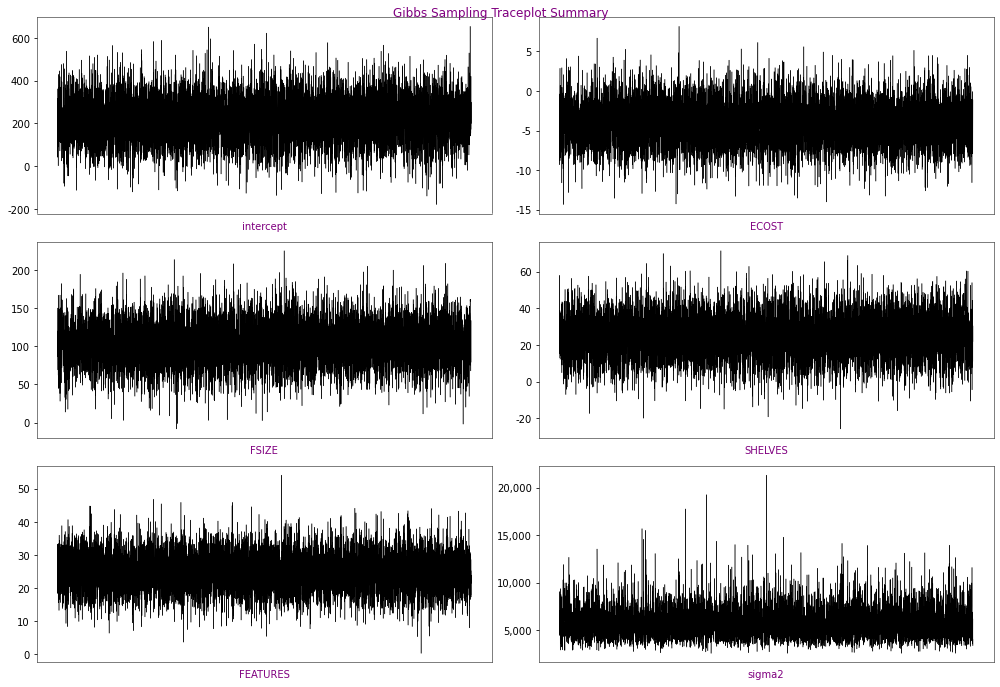

In [10]:
"""
Produce traceplot FacetGrid for regression parameters and sigma2. 
"""
TEXT_COLOR = "purple" #"#b000ff"
pltkwargs = {
    "color":"#000000", "linewidth":.45,
    }
grid = sns.FacetGrid(
    dfparams, col="VARIABLE", col_wrap=2, margin_titles=False, 
    despine=True, sharex=False, sharey=False,
    )
traceplot = grid.map(
    plt.plot, "SIM", "VALUE", **pltkwargs
    )
traceplot.fig.set_size_inches(
    14, 9.5
    )

# Identify each traceplot via x-axis label instead of facet title. 
grid.set_titles("{col_name}")
for ax in traceplot.axes.flatten():
    ax.set_xlabel(ax.get_title(), COLOR=TEXT_COLOR, labelpad=7.5, fontsize=10)
    ax.set_ylabel("")
    ax.set_title("")
    
    # Suppress x-axis ticks and ticklabels.
    ax.set_xticks([])
    
    # Suppress gridlines.
    ax.grid(False)
    
    # Draw border around each facet.
    for _, spine_ in ax.spines.items():
        spine_.set(visible=True, color="#000000", linewidth=.50)

    # Display thousandths separator on y-axis where applicable. 
    yticks = ax.get_yticks()[1:-1]
    yticklabs = ["{:,.0f}".format(i) for i in yticks]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabs, color="#000000")
    
# Specify tight_layout for facets. 
traceplot.fig.tight_layout(w_pad=0.5)
titlestr = "Gibbs Sampling Traceplot Summary"
traceplot.fig.suptitle(
    titlestr, x=.5, y=1, color=TEXT_COLOR,
    )

plt.show()


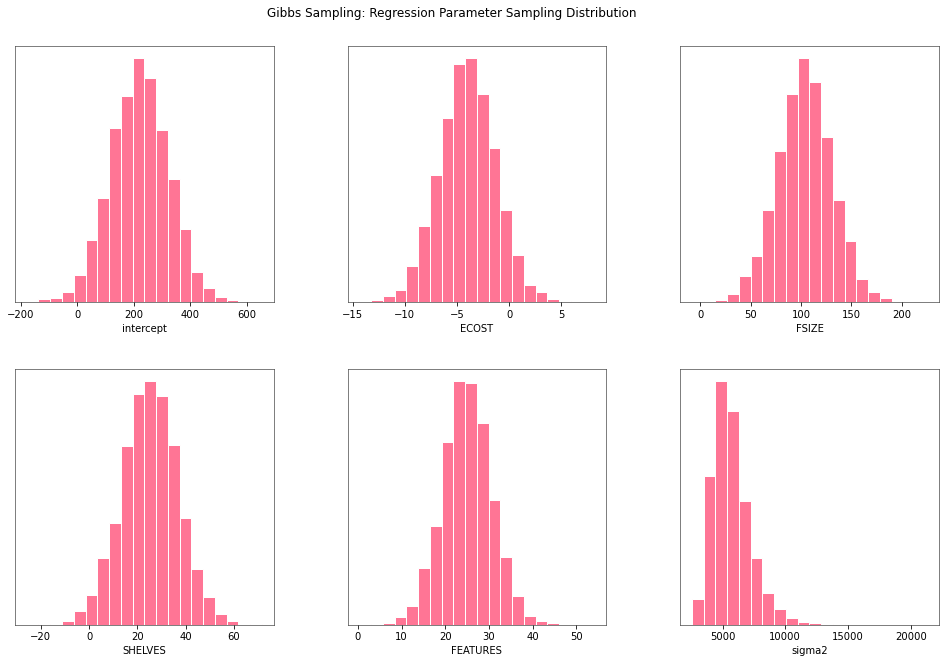

In [19]:
"""
Produce histogram FacetGrid for regression parameters and sigma2.
"""
sns.axes_style("darkgrid")
HISTCOLOR = "#ff7595" #"#b894ff"
NBRBINS = 20
TEXT_COLOR = "#000000" #"#b000ff" # "#484848"
histkwargs = {
    "color":HISTCOLOR, "edgecolor":"#FFFFFF", "alpha":1, "linewidth":1.,
    "bins":NBRBINS,
    }

grid = sns.FacetGrid(
    dfparams, col="VARIABLE", col_wrap=3, margin_titles=False, 
    despine=True, sharex=False, sharey=False,
    )
histplot = grid.map(
    plt.hist, "VALUE", **histkwargs
    )

histplot.fig.set_size_inches(14,9.5)

grid.set_titles("{col_name}")
for ax in histplot.axes.flatten():
    ax.set_xlabel(ax.get_title(), COLOR=TEXT_COLOR)
    ax.set_ylabel("")
    ax.set_title("")
    
    # Draw border around facet.
    for _, spine_ in ax.spines.items():
        spine_.set(visible=True, color="#000000", linewidth=.50)
        
    # Display thousandths separator on x and y axis where applicable. 
    xticks = ax.get_yticks()[1:-1]
    yticks = ax.get_yticks()[1:-1]
    xticklabs = ["{:,.0f}".format(i) for i in xticks]
    yticklabs = ["{:,.0f}".format(i) for i in yticks]
    ax.set_yticks([])

        
        
    
# histplot.fig.tight_layout(w_pad=2.25)
titlestr = "Gibbs Sampling: Regression Parameter Sampling Distribution"
histplot.fig.suptitle(
    titlestr, x=0.5, y=1, color=TEXT_COLOR, 
    )

plt.show()


## MCMC vs. Conjugate Multivariate Normal-Inverse Gamma Prior Estimates
---


The likelihood is given by:

$$
y|\beta, \sigma^{2} \sim \mathcal{N}(X\beta, \sigma^{2}I) = \Big(\frac{1}{2\pi\sigma^{2}}\Big)^{n/2}\mathrm{exp}\Big\{-\frac{1}{2\sigma^{2}}(y-X\beta)^{T}(y-X\beta)\Big\}
$$
<br>

The multivariate normal-inverse gamma prior distribution is conjugate to the likelihood and is given by:

$$
\begin{align}
[\beta, \sigma^{2}] &\sim \mathrm{NIG}(\mu_{\beta}, V_{\beta}, a, b),
\end{align}
$$
<br>

where an option for $V_{\beta}$ is  $p^{2}(X^{T}X)^{-1}$. The $\mathrm{NIG}$ distribution can be decomposed into the product of a multivariate normal (for $\beta$) and an inverse gamma prior (for $\sigma^{2}$):

$$
\begin{align}
f(\beta, \sigma^{2}) = f(\beta)f(\sigma^{2}) = \mathcal{N_{p}}(\mu_{\beta}, \sigma^{2}V_{\beta}) \times \mathrm{IG}(a, b) = \mathrm{NIG}(\mu_{\beta}, V_{\beta}, a, b),\\
\end{align}
$$
<br>

which, upon expansion becomes:

$$
\frac{b^{a}}{(2\pi)^{p/2}|V_{\beta}|^{1/2}\Gamma(a)} \Big(\frac{1}{\sigma^{2}}\Big)^{a+p/2+1} \times
\mathrm{exp}\Big[-\frac{1}{\sigma^{2}} \Big\{b + \frac{1}{2}(\beta - \mu_{\beta})^{T} V_{\beta}^{-1}(\beta - \mu_{\beta})\Big\}\Big].
$$
<br> 

The joint posterior distribution is given by:

$$
f(\beta, \sigma^{2}|y) \propto \Big(\frac{1}{\sigma^{2}}\Big)^{a+(n+p)/2+1} \times \mathrm{exp}\Big[-\frac{1}{\sigma^{2}} \Big\{\tilde{b} + \frac{1}{2}(\beta - \tilde{\beta})^{T} \tilde{\Sigma}^{-1}(\beta - \tilde{\beta})\Big\}\Big],
$$
<br>     

which is $\mathrm{NIG}(\tilde{\beta}, \tilde{\Sigma}, \tilde{a}, \tilde{b})$ with parameters:

$$
\begin{align}
\tilde{\beta} &= (V_{\beta}^{-1} + X^{T}X)^{-1}(V_{\beta}^{-1}\mu_{\beta} + X^{T}y)\\
\tilde{\Sigma} &= (V_{\beta}^{-1} + X^{T}X)^{-1}\\
\tilde{a} &= a + n/2\\
\tilde{b} &= b + \frac{1}{2}[\mu_{\beta}^{T}V_{\beta}^{-1}\mu_{\beta} + y^{T}y - \tilde{\beta}^{T}\tilde{\Sigma}^{-1}\tilde{\beta}]\\
\end{align}
$$


The posterior mean $\tilde{\beta}$ can be represented as a weighted average of the prior and sample means:

$$
\begin{align}
\tilde{\beta} &=W\hat{\beta} + (I_{p} - W)\mu_{\beta}\\
W &= \big(X^{T}X + V_{\beta}^{-1}\big)^{-1}X^{T}X\\
\hat{\beta} &= (X^{T}X)^{-1}X^{T}y\\
\end{align}
$$
<br>

where $\hat{\beta}$ is the maximum likelihood estimator. 
<br>


### Sampling from the Posterior Distribution

Sampling from the posterior $\mathrm{NIG}$ distribution proceeds as follows:

for each $i = 1 \cdots n$, do:

1. Sample $\sigma^{2(i)} \sim \mathrm{IG}(\tilde{a}, \tilde{b})$.
<br>
2. Sample $\beta^{(i)} \sim \mathcal{N}(\tilde{\beta}, \sigma^{2(i)}\tilde{\Sigma})$.      
<br>   

After $n$ iterations:

- $\{\beta^{(i)}, \sigma^{2(i)}\}_{i=1}^{n}$ provides samples from the joint posterior $f(\beta, \sigma^{2}|X, y)$.      
<br>
- $\{\beta^{(i)}\}_{i=1}^{n}$ provides samples from the marginal posterior $f(\beta|X, y)$.     
<br> 
- $\{\sigma^{2(i)}\}_{i=1}^{n}$ provides samples from the marginal posterior $f(\sigma^{2}|X, y)$.    
<br>   
<br>   


### Posterior Predictions

For a new $m \times p$ matrix of covariates $\tilde{X}$, we are interested in predicting the corresponding outcome $\tilde{y}$.
For each posterior sample $\{\beta^{(i)}, \sigma^{2(i)}\}$, draw $\hat{y} \sim \mathcal{N}(\tilde{X}\beta^{(i)}, \sigma^{2(i)}I_{m})$. 
The resulting $\{y^{(i)}\}_{i=1}^{m}$ represent samples from the posterior predictive distribution, which is multivariate student-t given by

$$
\begin{align}
f(\tilde{y}|y) &= \int f(\tilde{y}|\beta, \sigma^{2}) \times f(\beta, \sigma^{2}|X, y)d\beta d\sigma^{2}\\
&= \int \mathcal{N}(\tilde{X}\beta, \sigma^{2}I_{m}) \times \mathrm{NIG}(\tilde{\beta}, \tilde{\Sigma}, \tilde{a}, \tilde{b})d\beta d\sigma^{2}\\
&= MVSt_{2\tilde{a}}\Big(\tilde{X}\tilde{\beta}, \frac{\tilde{b}}{\tilde{a}}(I + \tilde{X}\tilde{\Sigma}\tilde{X}^{T}) \Big)
\end{align}
$$

<br>
<br>

The posterior predictive distribution has the same mean as the posterior distribution, but a greater variance since we are drawing a 
new data value.   
<br>

### Posterior with Non-Informative Prior

The *conditional posterior* of $\beta$ is given by:

$$
\beta|\sigma^{2}, X, y \sim \mathcal{N}(\hat{\beta}, \sigma^{2}(X^{T}X)^{-1})
$$
<br>

The *marginal posterior* of $\beta$ is:

$$
\beta|X, y \sim t_{p}(n - p, \hat{\beta}, s^{2}(X^{T}X)^{-1})
$$
<br>   

When using the non-informative improper prior, the *posterior predictive density* is given by:

$$
\tilde{y}|y \sim t_{n}\Big(\tilde{X}\tilde{\beta}, \frac{\tilde{b}}{\tilde{a}}(I + \tilde{X}\tilde{\Sigma}\tilde{X}^{T}) \Big)   
$$

## Bayesian Approach

- The posterior mode is the most likely value for $\theta$ after observing the data.  
<br>
- In contrast to frequentist inference, the Bayesian approach considers the unknown parameters $\beta$ and $\sigma^{2}$ as random variables.   
<br> 
- The Bayesian linear regression model is specified as $y = X\beta + \epsilon$ with $\mathrm{E}(\epsilon)$ and $\mathrm{Cov}(\epsilon) = \sigma^{2}I$.   
<br>
- The distribution of the response $y$ can be understood as conditional on the parameters $\beta$ and $\sigma^{2}$, and we obtain the following model for the observations: 

$$
y|\beta, \sigma^{2} \sim \mathcal{N}(X\beta, \sigma^{2}I)
$$
<br>


### Conjugate Multivariate Normal-Inverse Gamma Prior

The likelihood is given by:

$$
y|\beta, \sigma^{2} \sim \mathcal{N}(X\beta, \sigma^{2}I) = \Big(\frac{1}{2\pi\sigma^{2}}\Big)^{n/2}\mathrm{exp}\Big\{-\frac{1}{2\sigma^{2}}(y-X\beta)^{T}(y-X\beta)\Big\}
$$
<br>

The multivariate normal-inverse gamma prior distribution is conjugate to the likelihood and is given by:

$$
[\beta, \sigma^{2}] \sim \mathrm{NIG}(\mu_{\beta}, V, a, b),
$$
<br>

which can be expressed as a product of a multivariate normal distribution for $\beta$ and an inverse gamma prior for $\sigma^{2}$:

$$
\beta|\sigma^{2} \sim \mathcal{N_{p}}(\mu_{\beta}, \sigma^{2}V) \hspace{2.5em} \sigma^{2} \sim \mathrm{IG}(a, b).
$$
<br>

The resulting posterior is also normal-inverse gamma with parameters

$$
\begin{align}
\tilde{\beta} &= \tilde{\Sigma}\big(X^{T}y + V^{-1}\mu_{\beta}\big) \\
\tilde{\Sigma} &= \big(X^{T}X + V^{-1}\big) \\
\tilde{a} &=\frac{n}{2} + a \\
\tilde{b} &= \frac{SS}{2} + b \\
SS &= y^{T}y - \tilde{\beta}^{T}\tilde{\Sigma}^{-1}\tilde{\beta} + \mu_{\beta}^{T}V^{-1}\mu_{\beta}\\ \\
\end{align}
$$
<br>

The posterior mean can be written as a weighted average of the prior and the sample mean:

$$
\begin{align}
\tilde{\beta} &= W\hat{\beta} + (I_{p} - W)\mu_{\beta}\\
W &= \big(X^{T}X + V^{-1}\big)^{-1}X^{T}X \\
\hat{\beta} &= (X^{T}X)^{-1}X^{T}y \\
V &= n(X^{T}X)^{-1} \hspace{.5em} \mathrm{or} \hspace{.5em} gI_{p} \hspace{.5em} \text{for large}\hspace{.1em}g. \\ \\
\end{align}
$$
<br>

The marginal posterior of $\beta$ is multivariate-$t$ with parameters $\tilde{\beta}, \tilde{\Sigma}(\mathrm{SS} + 2b)/(n + 2a), n + 2s$.    
<br>
The marginal posterior of $\sigma^{2}$ is an inverse gamma distribution with $\tilde{a}, \tilde{b}$ from above.
<br>
<br>


### The Composition Method

Decompose the posterior as the product of the conditional distribution for the regression parameters given the error variance and the marginal distribution for the error variance parameter:

$$
\pi(\beta, \sigma^{2}|X, y) = \pi(\beta|\sigma^{2},X, y)\pi(\sigma^{2}|X, y)
$$

The marginal distribution for $\sigma^{2}$ is inverse gamma, and a sequence of draws from the appropriate IG distribution can be generated first. Then for each sampled $\sigma^{2}$, the conditional distribution of $\pi(\beta|\sigma^{2})$ is normal. 
<br>

The conditional distribution of $\beta$ for each $\sigma^{2}$ is given by:

$$
\beta|\sigma^{2},X,y \sim \mathcal{N}(\hat{\beta}, \sigma^{2}(X^{T}X)^{-1}),
$$

where $\hat{\beta} = (X^{T}X)^{-1}X^{T}y$.


The marginal distribution for $\sigma^{2}$ is obtained by integrating the posterior density over the regression parameter vector, resulting in an inverse gamma distribution with parameters $\alpha = (n - k)/2$ and $\beta = .5e^{T}e$, where $e = (y - X\hat{\beta})$.


### Likelihood Specification

The likelihood is the joint probability of observing the data given the parameters. Since $X$ is fixed, the likelihood is given by:

$$
f(y|X, \beta, \sigma^{2}) = \Big(\frac{1}{2\pi\sigma^{2}}\Big)^{n/2}\mathrm{exp}\Big\{-\frac{1}{2\sigma^{2}}(y - X\beta)^{T}(y - X\beta)\Big\}
$$


### Prior Specification

With no prior information, we specify a non-informative prior for $(\beta, \sigma^{2})$:

$$
\pi(\beta, \sigma^{2}) \propto \frac{1}{\sigma^{2}}.
$$


The conditional posterior distribution of $\beta$ given $\sigma^{2}$:

$$
\beta|\sigma^{2}, y \sim \mathcal{N}(\hat{\beta}, \sigma^{2}\mathbf{V}_{\beta}),
$$

where 

$$
\hat{\beta} = (X^{T}X)^{-1}X^{T}y \hspace{1.50em} \mathbf{V}_{\beta} = (X^{T}X)^{-1}.
$$


The marginal posterior distribution of $\sigma^{2}$:

$$
\sigma^{2}|y \sim IG\Big(\frac{n-k}{2}, \frac{(n-k)s^{2}}{2}\Big), \hspace{1.50em} s^{2} = \frac{1}{n-p}(y - X\hat{\beta})^{T}(y - X\hat{\beta})
$$
<br>  


The marginal posterior distribution $\pi(\beta|y)$, averaging over $\sigma^{2}$, is multivariate $t$ with $n-p$ degrees of freedom:

$$
\beta|y \sim t_{p}(n - p, \hat{\beta}, s^{2}(X^{T}X)^{-1}), \hspace{1.50em} s^{2} = y^{T}(I - H)y / (n - p),
$$

where $H=X(X^{T}X)^{-1}X^{T}$.

<br>







  

## Algorithm for Sampling from the Posterior Distribution (II of III)

(Sudipto Banerjee Slides; same as decomposition method from *Introduction to Applied Bayesian Statistics and Estimation for Social Scientists*)

<br>

1. Compute $\hat{\beta} = (X^{T}X)^{-1}X^{T}y\hspace{.50em}$ and $\hspace{.50em}V_{\beta} = (X^{T}X)^{-1}$.       
<br> 
2. Compute $s^{2} = \frac{1}{n-p}(y - X\hat{\beta})^{T}(y - X\hat{\beta})$.    
<br> 
3. Draw $M$ samples from  $IG\Big(\frac{n-k}{2}, \frac{(n-k)s^{2}}{2}\Big)$.      
<br>  
4. For $j = 1 \cdots M$, draw $\beta^{(j)}$ from $\mathcal{N}(\hat{\beta}, \sigma^{2}\mathbf{V}_{\beta})$.     
<br>  


Although the conditional distribution for the regression parameter vector is multivariate normal, the *marginal* distribution after integrating over $\sigma^{2}$ is multivariate-t. 



## Algorithm for Sampling from the Posterior Distribution (III of III)

(From Hoff, *A First Course in Bayesian Statistics*, chapter 9)
<br>


The likelihood is given by:

$$
\begin{align}
f(y|X,\beta,\sigma^{2}) &= \prod_{i=1}^{n} f(y_{i}|x_{i}, \beta, \sigma^{2}) \\
&= (2\pi\sigma^{2})^{-n/2} \mathrm{exp}\Big\{\frac{1}{2\sigma^{2}}\sum_{i=1}^{n} (y_{i} - \beta^{T}x_{i})^{2}\Big\},
\end{align}
$$

where $\sigma^{2}$ is the variance of $y$.
<br>
This density depends on $\beta$ through the residuals $(y_{i} - \beta^{T}x_{i})$. Given the observed data, the term in the exponent is maximized when the sum of squared residuals, $\mathrm{SSR} = \sum_{i=1}^{n} (y_{i} - \beta^{T}x_{i})^{2}$ is minimized. Also note that the sampling density as a function of $\beta$ can be written as:

$$
\begin{align}
f(y|X,\beta,\sigma^{2}) &\propto \mathrm{exp}\Big\{-\frac{1}{2\sigma^{2}}\mathrm{SSR}(\beta)\Big\} \\
&= \mathrm{exp} \Big\{-\frac{1}{2\sigma^{2}}\big[y^{T}y - 2\beta^{T}X^{T}y + \beta^{T}X^{T}X\beta\big]\Big\} \\
\end{align}
$$
<br>

If $\beta \sim \mathcal{N_{p}}(\beta_{0}, \Sigma_{0})$, then the full conditional for $\beta$ is proportional to a multivariate normal density with:

$$
\begin{align}
\mathrm{Var}(\beta|y,X,\sigma^{2}) &= (\Sigma_{0}^{-1} + X^{T}X/\sigma^{2})^{-1} \\
\mathrm{E}(\beta|y,X,\sigma^{2}) &= (\Sigma_{0}^{-1} + X^{T}X/\sigma^{2})^{-1}(\Sigma_{0}^{-1}\beta_{0} + X^{T}y/\sigma^{2})\\
\end{align}
$$

Note that $\Sigma_{0}^{-1}$ is the prior precision matrix.

If elements of $\Sigma_{0}^{-1}$ are small, then the conditional expectation $E(\beta|y,X,\sigma^{2})$ is approximately equal to $(X^{T}X)^{-1}X^{T}y$, the OLS estimate. On the other hand, if the measurement precision is very small ($\sigma^{2}$ is very large), then the expectation is approximately $\beta_{0}$, the prior expectation. 
<br>   
The full conditional for $\sigma^{2}$ is:

$$
\sigma^{2}|y, X, \beta \sim \mathrm{IG}([\nu_{0}+n]/2, [\nu_{0}\sigma_{0}^{2} + \mathrm{SSR}(\beta)]/2).
$$

The Gibbs sampler to approximate the joint posterior distribution $\pi(\beta, \sigma^{2}|y, X)$ is straightforward. Given current values $[\beta^{(i)}, \sigma^{2(i)}]$, new values are obtained as follows:

1. Compute $V = \mathrm{Var}(\beta|y,X,\sigma^{2(i)})$ and $\mu = \mathrm{E}(\beta|y,X,\sigma^{2(i)})$.          
<br>
2. Sample $\beta^{(i+1)} \sim \mathcal{N}_{p}(\mu, V)$.      
<br>
3. Compute $\mathrm{SSR}(\beta^{(i+1)})$.  
<br>
4. Sample $\sigma^{2(i+1)} \sim \mathrm{IG}([\nu_{0}+n]/2, [\nu_{0}\sigma_{0}^{2} + \mathrm{SSR}(\beta^{(i+1)})]/2)$.
<br>

(page 155)
Note however that a Bayesian analysis of a regression model requires specification of the prior parameters $(\beta_{0}, \Sigma_{0})$ and $(\nu_{0}, \sigma_{0}^{2})$. The *unit information prior* sets

$$
\begin{align}
\Sigma_{0} &= n\sigma^{2}(X^{T}X)^{-1} \\
\beta_{0} &= (X^{T}X)^{-1}X^{T}y \\
\nu_{0} &= 1 \\
\sigma_{0}^{2} &= \hat{\sigma}_{ols}^{2} \\
\end{align}
$$